# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [1]:
from unityagents import UnityEnvironment
import numpy as np

# Load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [4]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.08799999803304673


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal


class ActorNetwork(nn.Module):
    """
    Actor is a policy network. Given state it evaluates 
    probability of action given state or sample an action
    """
    def __init__(self, state_size, action_size, seed=42, hidden_size1=64, hidden_size2=64):
        super(ActorNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.layer1 = nn.Linear(state_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.mu = nn.Linear(hidden_size2, action_size)
        self.sigma = nn.Linear(hidden_size2, action_size)

    def forward(self, states, actions=None):
        x = torch.tanh(self.layer1(states))
        x = torch.tanh(self.layer2(x))
        mu = torch.tanh(self.mu(x)) # To keep actions in [-1, 1]
        cov = F.softplus(self.sigma(x)) # Make matrix positive definite
        cov = torch.diag_embed(cov) # Distibute covariances
        action_dist = MultivariateNormal(mu, cov)
        actions = actions if actions is not None else action_dist.sample()
        action_log_prob = action_dist.log_prob(actions)
        entropy = action_dist.entropy()
        return actions.detach(), action_log_prob.unsqueeze(1), entropy

In [6]:
class CriticNetwork(nn.Module):
    """
    Critic network estimates value function
    """

    def __init__(self, state_size, seed=42, hidden_size1=64, hidden_size2=64):
        super(CriticNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.layer1 = nn.Linear(state_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.layer3 = nn.Linear(hidden_size2, 1)

    def forward(self, states):
        x = F.relu(self.layer1(states))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [7]:
class ActorCritic(nn.Module):
    """
    Actor-critic model
    """
    
    def __init__(self, state_size, action_size):
        super(ActorCritic, self).__init__()
        self.actor = ActorNetwork(state_size, action_size)
        self.critic = CriticNetwork(state_size)
        
    def act(self, states):
        actions, _, _ = self.actor.forward(states, None)
        return actions
    
    def evaluate(self, states, actions):
        _, logprobs, entropy = self.actor.forward(states, actions)
        values = self.critic.forward(states)
        return values, logprobs, entropy

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class Memory():
    """
    Memory buffer for saving trajectories
    """
    
    def __init__(self):
        self.states = []
        self.next_states = []
        self.actions = []
        self.rewards = []
        self.dones = []
    
    def clear(self):
        del self.states[:]
        del self.next_states[:]
        del self.actions[:]
        del self.rewards[:]
        del self.dones[:]
        
    def get_trajectory(self, actor_i):
        to_torch = lambda arr: torch.from_numpy(arr).to(device).float()
        actor_slice = lambda arr: np.array([a[actor_i] for a in arr])
        actions = to_torch(actor_slice(self.actions))
        states = to_torch(actor_slice(self.states))
        next_states = to_torch(actor_slice(self.next_states))
        rewards = actor_slice(self.rewards).reshape(-1, 1)
        dones = actor_slice(self.dones).reshape(-1, 1)
        return states, actions, rewards, next_states, dones

cpu


## PPO agent

I implemented proximal policy optimization method actor-critic style clipping surrogate loss and generalized advances estimator. See for the reference paper [here](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf).

#### Algorithm used:  
<p><img src="ppo.png" width="500"/></p>
</br>

#### Clipping suroogate loss for policy optimization:  
<p><img src="clipping.png" width="300"/></p>  

#### Generalized advances estimator formula used:  
<p><img src="gae.png" width="300"/></p>  
</br>

In [9]:
class PPOAgent():
    
    def __init__(self, action_size, state_size, n_actors, actor_critic=None, T=128, K_epochs=10, lr=5e-4, 
                 lamb=0.8, gamma=0.97, eps=0.2, c1 = 0.5, c2 = 0.01):
        """Initializes agent object
        
        Args:
         action_size - action space dimensions
         state_size - state space dimensions
         n_actors - number of actors, equals to number of distriburted envirionments
         actor_critic - pretrained actor-critic network
         T - time steps to collect before agent updating
         K_epochs - number of steps while optimizing networcs
         lr - learning rate for Adam optimizer
         lamb - smoothing parameter for generalized advantage estimator
         gamma - decay
         eps - clipping threshold
         c1 - weight for critic loss
         c2 - weight for entropy loss
         
        """
        self.policy = ActorCritic(state_size, action_size).to(device)
        if actor_critic is not None:
            self.policy.load_state_dict(actor_critic.state_dict())
            
        self.policy_old = ActorCritic(state_size, action_size).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.memory = Memory()
        self.n_actors = n_actors
        self.T = T
        self.K_epochs = K_epochs
        self.c1 = c1
        self.c2 = c2
        self.lamb = lamb
        self.gamma = gamma
        self.epsilon = eps
        self.mse_loss = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)

    def act(self, states):
        """Takes actions given batch of states
        
        Args:
         states - a batch of states
        
        Returns:
         actions - a batch of actions generated given states
        """
        states = torch.from_numpy(states).float().to(device)
        with torch.no_grad():
            actions = self.policy_old.act(states)
            return actions.detach().cpu().numpy()
    
    def update(self, states, actions, rewards, next_states, dones):
        """Updates actor critic network
        
        Args:
         states - states for parallel agents, shape [n_agents x state_size]
         actions - actions for parallel agents, shape [n_agents x action_size]
         rewards - rewards for parallel agents, shape [n_agents x 1]
         next_states - next states for parallel agents, shape [n_agents x state_size]
         dones - edisode finishing flags for parallel agents, shape [n_agents x 1]
         
        """
              
        # Add to memory untill collect trajectories of length memory_size
        if len(self.memory.states) < self.T:
            self.memory.actions.append(actions)
            self.memory.states.append(states)
            self.memory.rewards.append(rewards)
            self.memory.next_states.append(next_states)
            self.memory.dones.append(dones)
            return
                
        # Optimize   
        for _ in range(self.K_epochs):
            loss = self._compute_loss()
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.memory.clear()
    
    def save(self, f):
        """Saves policy network to file
        
        Args:
         f - output file  
        """
        torch.save(self.policy.state_dict(), f)
        

    def _compute_loss(self):
        
        # Iterate over actors and create batch
        loss = 0
        for actor_i in range(self.n_actors):
            
            states, actions, rewards, next_states, dones = self.memory.get_trajectory(actor_i)
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-5)
            rewards_to_go = self._compute_rewards_to_go(rewards, dones)

            values, logprobs, S = self.policy.evaluate(states, actions)
            
            with torch.no_grad():
                values_old, logprobs_old, _ = self.policy_old.evaluate(states, actions)
                values_next_old, _, _ = self.policy_old.evaluate(next_states, None)
                values_old = values_old.detach().cpu().numpy()
                values_next_old = values_next_old.detach().cpu().numpy()
                
            ratios = torch.exp(logprobs - logprobs_old.detach())
            advantages = self._compute_advantages(rewards, values_old, values_next_old, dones)
        
            # Compute surrogate loss with clipping
            s1 = ratios * advantages
            s2 = torch.clamp(ratios, 1 - self.epsilon, 1 + self.epsilon) * advantages
            L_clip = torch.min(s1, s2)

            # Compute MSE loss for value functions
            L_vf = self.mse_loss(values, rewards_to_go)
            
            # Combine losses
            loss += -L_clip.mean() + self.c1*L_vf - self.c2*S.mean()
            
        return loss/self.n_actors
    
    def _compute_advantages(self, rewards, values, next_values, dones):
        td_errors = rewards + self.gamma*next_values*(1-dones) - values
        A, advantages = 0, []
        for t in reversed(range(len(td_errors))):
            A = td_errors[t] + (self.lamb * self.gamma)*A*(1-dones[t])
            advantages.insert(0, A)
        return torch.from_numpy(np.array(advantages)).float().to(device)
        
 
    def _compute_rewards_to_go(self, rewards, dones):
        rewards_to_go = []
        R = 0
        for reward, done in zip(reversed(rewards), reversed(dones)):
            R = reward + self.gamma * R * (1-done)
            rewards_to_go.insert(0, R)
        return torch.from_numpy(np.array(rewards_to_go)).float().reshape(-1, 1).to(device)

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def run_episode(agent, i, train_mode=True):
    """
    A helper method to run single episode and print metrics
    
    """
    env_info = env.reset(train_mode)[brain_name]        
    states = env_info.vector_observations                  
    scores = np.zeros(num_agents)
    step = 1
    while True:
        actions = agent.act(states) 
        env_info = env.step(actions)[brain_name]           
        next_states = env_info.vector_observations         
        rewards = env_info.rewards                         
        dones = env_info.local_done  
        agent.update(states, actions, rewards, next_states, dones)
        scores += env_info.rewards
        states = next_states
        step += 1
        if np.any(dones):   
            break
            
    if i%10==0:
        print('Total score (averaged over agents) episode {}: {}'.format(i, np.mean(scores)))
    return np.mean(scores)

def run_episodes_and_display(agent, n_episodes=200):
    """
    Runs a series of episode and display agent's performance
    
    """
    
    display_step = 100
    score = 0
    score_sum = 0
    scores = []
    for episode in range(1, n_episodes+1):
        score = run_episode(agent, episode, train_mode=True)
        score_sum += score
        scores.append(score)
        if episode%display_step==0:
            avg_score = score_sum/display_step
            score_sum = 0
            if avg_score > 30:
                print("Environment is solved! Average score over 100 episodes > 30.")
                break
            
    fig = plt.figure()
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Max Score')
    plt.xlabel('Episode #')
    plt.show()

Total score (averaged over agents) episode 10: 1.328499970305711
Total score (averaged over agents) episode 20: 4.38949990188703
Total score (averaged over agents) episode 30: 8.47149981064722
Total score (averaged over agents) episode 40: 17.693499604519456
Total score (averaged over agents) episode 50: 21.987999508529903
Total score (averaged over agents) episode 60: 27.79149937881157
Total score (averaged over agents) episode 70: 34.186999235861
Total score (averaged over agents) episode 80: 38.459499140363185
Total score (averaged over agents) episode 90: 38.6669991357252
Total score (averaged over agents) episode 100: 38.80599913261831
Total score (averaged over agents) episode 110: 38.03999914973974
Total score (averaged over agents) episode 120: 38.75849913368002
Total score (averaged over agents) episode 130: 38.71499913465232
Total score (averaged over agents) episode 140: 38.54699913840741
Total score (averaged over agents) episode 150: 38.87449913108721
Total score (averaged

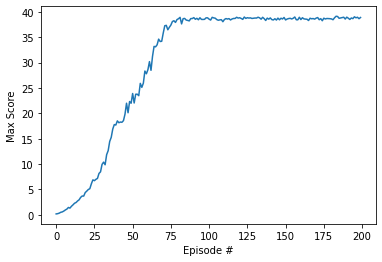

CPU times: user 40min 57s, sys: 3min 31s, total: 44min 28s
Wall time: 46min 53s


In [14]:
%%time

agent = PPOAgent(action_size, state_size, num_agents, 
                 T=512, 
                 K_epochs=20, 
                 lr=5e-4, 
                 gamma=0.99, 
                 lamb=0.99, 
                 eps=0.2, 
                 c1=0.5, 
                 c2=0.01)

run_episodes_and_display(agent, n_episodes = 300)

In [15]:
agent.save("./actor_critic.pt")

In [16]:
env.close()

## Further work

This implementation of algorithm is not optimal and can be improved at least in two ways:
1) I used loop over agents to calculate loss functions. This can be done rather in batch mode without for loop.  
2) I evaluate values of states and next_states separately so I need to forward propagate critic network twice. This can be done in one pass some way.  
  
  
I also may try different loss e.g. with KL-divergence regulariztion and also search for better parameters of clipping, entropy and critic loss weights.  
Also different variations of network architectures can be used as further imporvement.
